In [37]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [38]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64
NUM_EPOCHS = 15
LR = 0.00001

In [39]:
def load_and_prep_cifar(batch_size, shuffle_buffer_size):

  train, test = tfds.load('cifar10', split= ['train', 'test'], as_supervised=True)

  def preprocessing_func(img, label):
    img = tf.cast(img, tf.float32)
    img = (img/128) -1
    label = tf.one_hot(label, depth=10)
    return img, label

  train = train.map(lambda img, label: preprocessing_func(img, label))
  train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(2)

  test = test.map(lambda img, label: preprocessing_func(img, label))
  test = test.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(2)

  return train, test

In [40]:
train_dataset, test_dataset = load_and_prep_cifar(BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

Ship


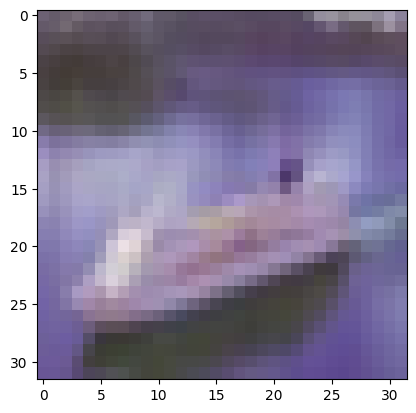

In [41]:
for x, t in train_dataset.take(1):
  plt.imshow((x[0] + 1) / 2)

  label = tf.argmax(t[0]).numpy()
  classes = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
  print(classes[label])

In [42]:
class BasicConv(tf.keras.Model):
    def __init__(self):
        super(BasicConv, self).__init__()

        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x


In [43]:
class DenselyConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filters):
    super(DenselyConnectedCNNLayer, self).__init__()
    self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu')

  def call(self, x):
    c = self.conv(x)
    x = tf.concat((x,c), axis=-1)
    return x

class DenselyConnectedCNNBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, layers):
    super(DenselyConnectedCNNBlock, self).__init__()
    self.layers = [DenselyConnectedCNNLayer(num_filters) for _ in range(layers)]

  def call(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


class DenselyConnectedCNN(tf.keras.Model):
  def __init__(self):
    super(DenselyConnectedCNN, self).__init__()

    self.denseblock1 = DenselyConnectedCNNBlock(24,4)
    self.pooling1 = tf.keras.layers.MaxPooling2D()

    self.denseblock2 = DenselyConnectedCNNBlock(24,4)
    self.pooling2 = tf.keras.layers.MaxPooling2D()

    self.denseblock3 = DenselyConnectedCNNBlock(24,4)
    self.globalpooling = tf.keras.layers.GlobalAvgPool2D()
    self.out = tf.keras.layers.Dense(10, activation='softmax')

  def call(self,x):
    x = self.denseblock1(x)
    x = self.pooling1(x)
    x = self.denseblock2(x)
    x = self.pooling2(x)
    x = self.denseblock3(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x


In [44]:
def testing(model, data, loss_function):

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in data:

      prediction = model(input)
      sample_test_loss = loss_function(target, prediction)
      sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
      sample_test_accuracy = np.mean(sample_test_accuracy)
      test_loss_aggregator.append(sample_test_loss.numpy())
      test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    mean_loss = tf.reduce_mean(test_loss_aggregator)
    mean_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return mean_loss, mean_accuracy

In [45]:
def train(model, optimizer, test_dataset, train_dataset, loss_f, num_epochs, batch_size, shuffle_buffer_size, lr):

  #optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  train_losses =[]
  train_accuracies = []
  test_losses = []
  test_accuracies = []

  # all the mean losses of every epoch
  #loss_per_epoch = []

  for epoch in range(num_epochs):

    # test model with train dataset in every epoch
    trainD_mean_loss, trainD_mean_accuracy = testing(model, train_dataset, loss_f)
    train_losses.append(trainD_mean_loss)
    train_accuracies.append(trainD_mean_accuracy)

    # test model with test dataset in every epoch
    testD_mean_loss, testD_mean_accuracy = testing(model, test_dataset, loss_f)
    test_losses.append(testD_mean_loss)
    test_accuracies.append(testD_mean_accuracy)

    print(f'Epoch: {str(epoch)} starting with test accuracy {test_accuracies[-1]}')

    # all the losses for all x and t in this epoch
    #losses_in_epoch = []

    # train model on train dataset
    for x, t in train_dataset:
      with tf.GradientTape() as tape:
        pred = model(x)
        l = loss_f(t, pred)
      gradients = tape.gradient(l, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))

      #losses_in_epoch.append(l)

    #loss_per_epoch.append(tf.reduce_mean(losses_in_epoch))


  return model, train_losses, train_accuracies, test_losses, test_accuracies


In [46]:
tf.keras.backend.clear_session()

# Initialize lists for later visualization.
# train_losses = []
# test_losses = []
# test_accuracies = []
# train_accuracies = []

model_0 = BasicConv()
loss_f_0 = tf.keras.losses.CategoricalCrossentropy()
optimizer_0 = tf.keras.optimizers.Adam(learning_rate=LR)

# #testing once before we begin
# test_loss, test_accuracy = testing(model, test_dataset, loss_f)
# test_losses.append(test_loss)
# test_accuracies.append(test_accuracy)

# #check how model performs on train data once before we begin
# train_loss, train_accuracy = testing(model, train_dataset, loss_f)
# train_losses.append(train_loss)
# train_accuracies.append(train_accuracy)

trained_model_0, train_losses_0, train_accuracies_0, test_losses_0, test_accuracies_0 = train(model_0, optimizer_0, train_dataset, test_dataset, loss_f_0, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)

# #appending lists with loss and accuracy data collected during taining
# train_losses += train_l
# test_losses += test_l
# test_accuracies += test_a


Epoch: 0 starting with test accuracy 0.09938459079283887
Epoch: 1 starting with test accuracy 0.13768781969309463
Epoch: 2 starting with test accuracy 0.14452125959079284
Epoch: 3 starting with test accuracy 0.14675911125319693
Epoch: 4 starting with test accuracy 0.152653452685422
Epoch: 5 starting with test accuracy 0.17557145140664962
Epoch: 6 starting with test accuracy 0.18943813938618925
Epoch: 7 starting with test accuracy 0.19645140664961636
Epoch: 8 starting with test accuracy 0.201326726342711
Epoch: 9 starting with test accuracy 0.20682145140664962
Epoch: 10 starting with test accuracy 0.2172314578005115
Epoch: 11 starting with test accuracy 0.2249640345268542
Epoch: 12 starting with test accuracy 0.23197730179028134
Epoch: 13 starting with test accuracy 0.23497442455242967
Epoch: 14 starting with test accuracy 0.2395899936061381


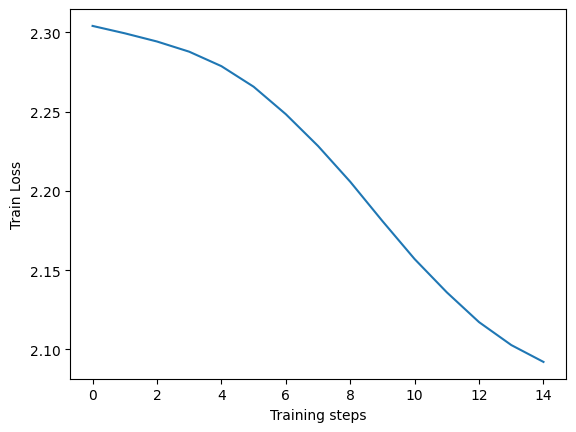

In [47]:
# Visualize accuracy and loss for training and test data.

plt.figure()
line1 = plt.plot(train_losses_0)
plt.xlabel("Training steps")
plt.ylabel("Train Loss")
plt.show()

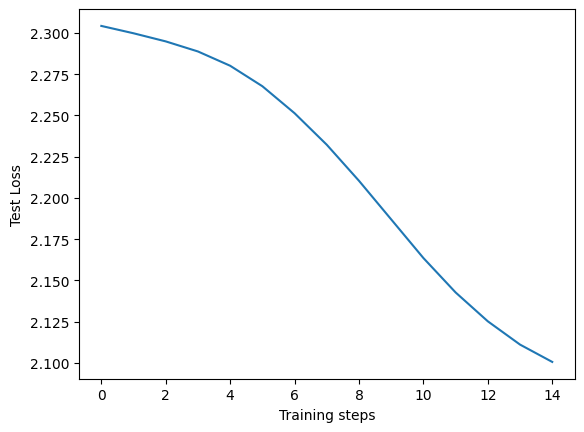

In [48]:
plt.figure()
line1 = plt.plot(test_losses_0)
plt.xlabel("Training steps")
plt.ylabel("Test Loss")
plt.show()

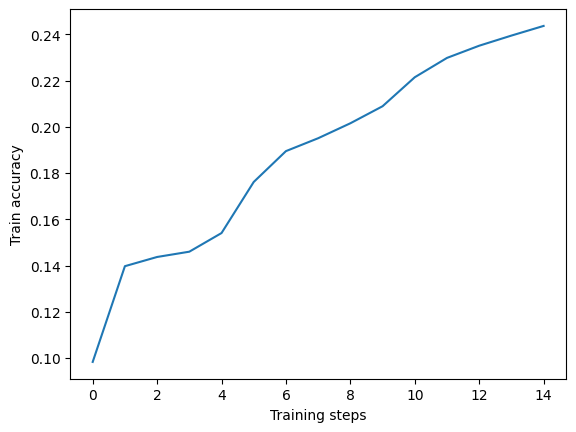

In [49]:
plt.figure()
line1 = plt.plot(train_accuracies_0)
plt.xlabel("Training steps")
plt.ylabel("Train accuracy")
plt.show()

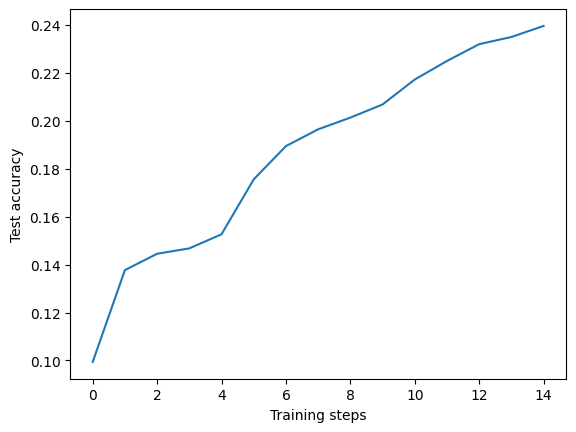

In [50]:
plt.figure()
line1 = plt.plot(test_accuracies_0)
plt.xlabel("Training steps")
plt.ylabel("Test accuracy")
plt.show()

In [51]:
# compared to casse 0: different learning rate

tf.keras.backend.clear_session()

model_1 = BasicConv()
loss_f_1 = tf.keras.losses.CategoricalCrossentropy()
optimizer_1 = tf.keras.optimizers.Adam(learning_rate = 0.01)


trained_model_1, train_losses_1, train_accuracies_1, test_losses_1, test_accuracies_1 = train(model_1, optimizer_1, train_dataset, test_dataset, loss_f_1, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, 0.01)

Epoch: 0 starting with test accuracy 0.09199168797953965
Epoch: 1 starting with test accuracy 0.24944053708439898
Epoch: 2 starting with test accuracy 0.31849424552429667
Epoch: 3 starting with test accuracy 0.33741608056265987
Epoch: 4 starting with test accuracy 0.3506633631713555
Epoch: 5 starting with test accuracy 0.3810342071611253
Epoch: 6 starting with test accuracy 0.40744884910485935
Epoch: 7 starting with test accuracy 0.4133631713554987
Epoch: 8 starting with test accuracy 0.41384271099744246
Epoch: 9 starting with test accuracy 0.3987971547314578
Epoch: 10 starting with test accuracy 0.4091871803069054
Epoch: 11 starting with test accuracy 0.4439538043478261
Epoch: 12 starting with test accuracy 0.4281689578005115
Epoch: 13 starting with test accuracy 0.4186181265984655
Epoch: 14 starting with test accuracy 0.4428148976982097


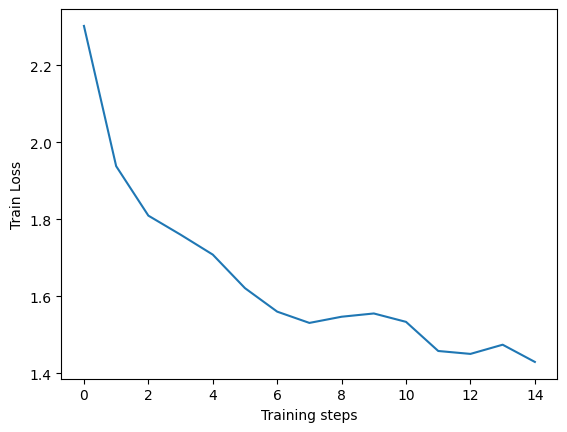

In [52]:
# Visualize accuracy and loss for training and test data.

plt.figure()
line1 = plt.plot(train_losses_1)
plt.xlabel("Training steps")
plt.ylabel("Train Loss")
plt.show()

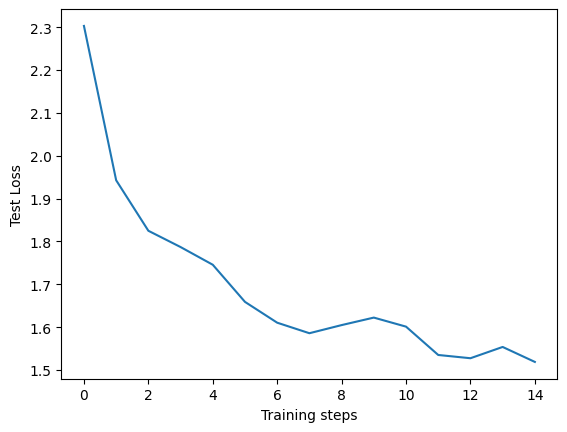

In [53]:
plt.figure()
line1 = plt.plot(test_losses_1)
plt.xlabel("Training steps")
plt.ylabel("Test Loss")
plt.show()

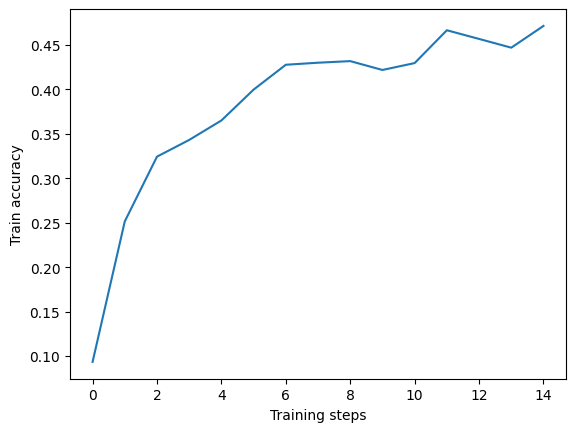

In [54]:
plt.figure()
line1 = plt.plot(train_accuracies_1)
plt.xlabel("Training steps")
plt.ylabel("Train accuracy")
plt.show()

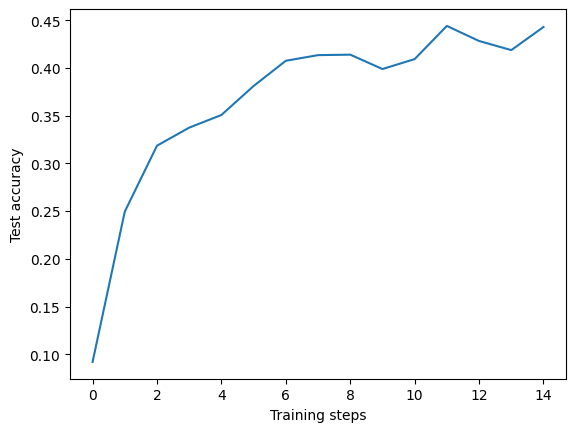

In [55]:
plt.figure()
line1 = plt.plot(test_accuracies_1)
plt.xlabel("Training steps")
plt.ylabel("Test accuracy")
plt.show()

In [56]:
# compared to case 0: different architecture

tf.keras.backend.clear_session()

model_2 = DenselyConnectedCNN()
loss_f_2 = tf.keras.losses.CategoricalCrossentropy()
optimizer_2 = tf.keras.optimizers.Adam(learning_rate=LR)


trained_model_2, train_losses_2, train_accuracies_2, test_losses_2, test_accuracies_2 = train(model_2, optimizer_2, train_dataset, test_dataset, loss_f_2, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)

Epoch: 0 starting with test accuracy 0.11782688618925831
Epoch: 1 starting with test accuracy 0.17804907289002558
Epoch: 2 starting with test accuracy 0.23111812659846548
Epoch: 3 starting with test accuracy 0.24822170716112532
Epoch: 4 starting with test accuracy 0.26376678388746805
Epoch: 5 starting with test accuracy 0.28552589514066495
Epoch: 6 starting with test accuracy 0.29018142583120204
Epoch: 7 starting with test accuracy 0.3016304347826087
Epoch: 8 starting with test accuracy 0.3139985613810742
Epoch: 9 starting with test accuracy 0.3228500639386189
Epoch: 10 starting with test accuracy 0.3302829283887468
Epoch: 11 starting with test accuracy 0.329923273657289
Epoch: 12 starting with test accuracy 0.3431505754475703
Epoch: 13 starting with test accuracy 0.34964434143222506
Epoch: 14 starting with test accuracy 0.3501238810741688


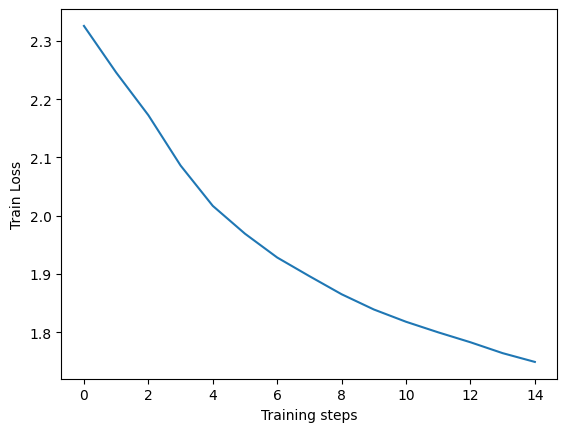

In [57]:
plt.figure()
line1 = plt.plot(train_losses_2)
plt.xlabel("Training steps")
plt.ylabel("Train Loss")
plt.show()

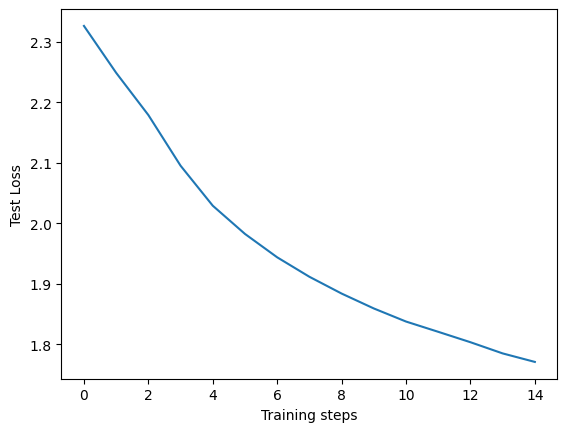

In [58]:
plt.figure()
line1 = plt.plot(test_losses_2)
plt.xlabel("Training steps")
plt.ylabel("Test Loss")
plt.show()

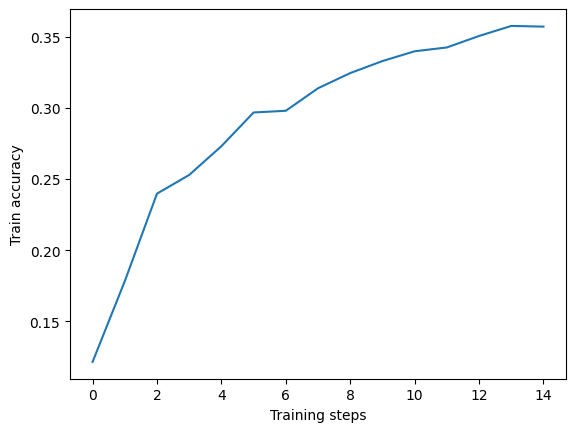

In [59]:
plt.figure()
line1 = plt.plot(train_accuracies_2)
plt.xlabel("Training steps")
plt.ylabel("Train accuracy")
plt.show()

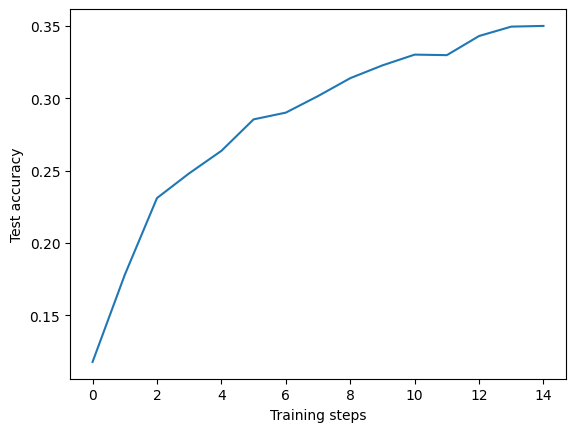

In [60]:
plt.figure()
line1 = plt.plot(test_accuracies_2)
plt.xlabel("Training steps")
plt.ylabel("Test accuracy")
plt.show()

In [61]:
# compared to case 0: different optimizer

tf.keras.backend.clear_session()

model_3 = BasicConv()
loss_f_3 = tf.keras.losses.CategoricalCrossentropy()
optimizer_3 = tf.keras.optimizers.SGD(learning_rate=LR)


trained_model_3, train_losses_3, train_accuracies_3, test_losses_3, test_accuracies_3 = train(model_3, optimizer_3, train_dataset, test_dataset, loss_f_3, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)

Epoch: 0 starting with test accuracy 0.09700687340153452
Epoch: 1 starting with test accuracy 0.09698689258312021
Epoch: 2 starting with test accuracy 0.09716671994884911
Epoch: 3 starting with test accuracy 0.09710677749360613
Epoch: 4 starting with test accuracy 0.09714673913043478
Epoch: 5 starting with test accuracy 0.09716671994884911
Epoch: 6 starting with test accuracy 0.09714673913043478
Epoch: 7 starting with test accuracy 0.09728660485933503
Epoch: 8 starting with test accuracy 0.09716671994884911
Epoch: 9 starting with test accuracy 0.09722666240409207
Epoch: 10 starting with test accuracy 0.09744645140664962
Epoch: 11 starting with test accuracy 0.09740648976982097
Epoch: 12 starting with test accuracy 0.09734654731457801
Epoch: 13 starting with test accuracy 0.09734654731457801
Epoch: 14 starting with test accuracy 0.09734654731457801


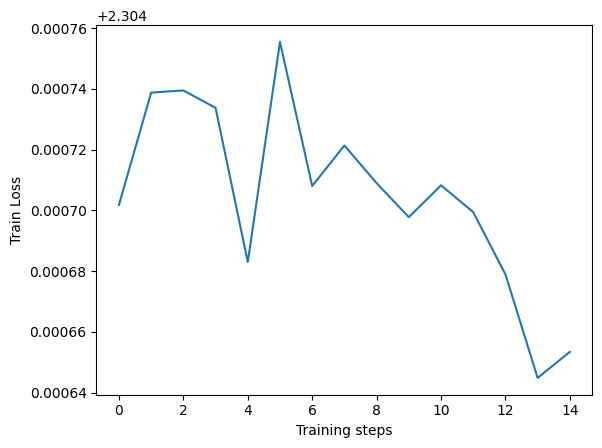

In [62]:
plt.figure()
line1 = plt.plot(train_losses_3)
plt.xlabel("Training steps")
plt.ylabel("Train Loss")
plt.show()

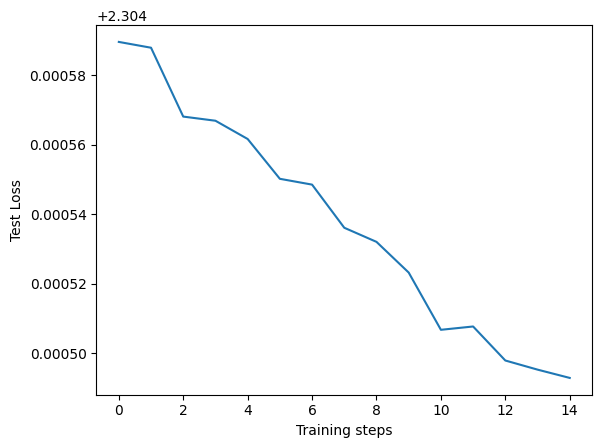

In [63]:
plt.figure()
line1 = plt.plot(test_losses_3)
plt.xlabel("Training steps")
plt.ylabel("Test Loss")
plt.show()

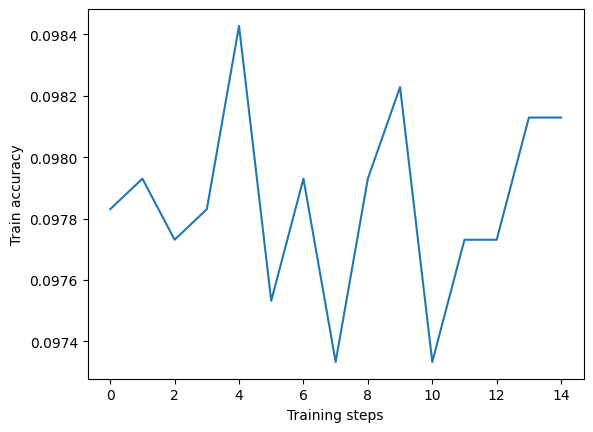

In [64]:
plt.figure()
line1 = plt.plot(train_accuracies_3)
plt.xlabel("Training steps")
plt.ylabel("Train accuracy")
plt.show()

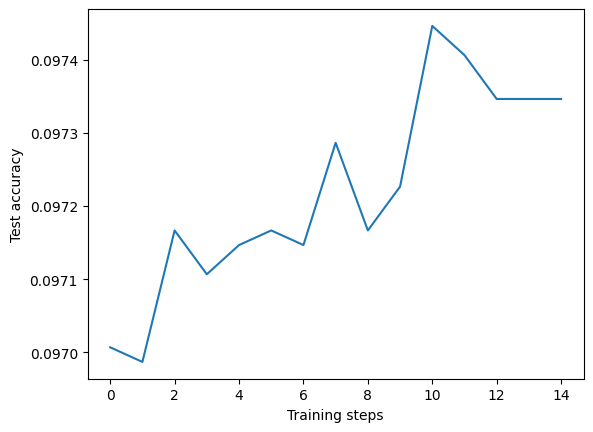

In [65]:
plt.figure()
line1 = plt.plot(test_accuracies_3)
plt.xlabel("Training steps")
plt.ylabel("Test accuracy")
plt.show()

In [ ]:
# compared to case 0: different learning rate + different architecture

tf.keras.backend.clear_session()

model_4 = DenselyConnectedCNN()
loss_f_4 = tf.keras.losses.CategoricalCrossentropy()
optimizer_4 = tf.keras.optimizers.Adam(learning_rate= 0.01)


trained_model_4, train_losses_4, train_accuracies_4, test_losses_4, test_accuracies_4 = train(model_4, optimizer_4, train_dataset, test_dataset, loss_f_4, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, 0.01)

Epoch: 0 starting with test accuracy 0.08963395140664962
Epoch: 1 starting with test accuracy 0.28802349744245526
Epoch: 2 starting with test accuracy 0.3931625639386189
Epoch: 3 starting with test accuracy 0.4475303708439898
Epoch: 4 starting with test accuracy 0.47919996803069054
Epoch: 5 starting with test accuracy 0.5092311381074168
Epoch: 6 starting with test accuracy 0.5176230818414322
Epoch: 7 starting with test accuracy 0.5185022378516624
Epoch: 8 starting with test accuracy 0.5334678708439897


In [ ]:
plt.figure()
line1 = plt.plot(train_losses_4)
plt.xlabel("Training steps")
plt.ylabel("Train Loss")
plt.show()

In [ ]:
plt.figure()
line1 = plt.plot(test_losses_4)
plt.xlabel("Training steps")
plt.ylabel("Test Loss")
plt.show()

In [ ]:
plt.figure()
line1 = plt.plot(train_accuracies_4)
plt.xlabel("Training steps")
plt.ylabel("Train accuracy")
plt.show()

In [ ]:
plt.figure()
line1 = plt.plot(test_accuracies_4)
plt.xlabel("Training steps")
plt.ylabel("Test accuracy")
plt.show()

In [ ]:
# compared to case 0: different learning rate + different optimizer

tf.keras.backend.clear_session()

model_5 = BasicConv()
loss_f_5 = tf.keras.losses.CategoricalCrossentropy()
optimizer_5 = tf.keras.optimizers.SGD(learning_rate= 0.01)


trained_model_5, train_losses_5, train_accuracies_5, test_losses_5, test_accuracies_5 = train(model_5, optimizer_5, train_dataset, test_dataset, loss_f_5, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, 0.01)

In [ ]:
plt.figure()
line1 = plt.plot(train_losses_5)
plt.xlabel("Training steps")
plt.ylabel("Train Loss")
plt.show()

In [ ]:
plt.figure()
line1 = plt.plot(test_losses_5)
plt.xlabel("Training steps")
plt.ylabel("Test Loss")
plt.show()

In [ ]:
plt.figure()
line1 = plt.plot(train_accuracies_5)
plt.xlabel("Training steps")
plt.ylabel("Train accuracy")
plt.show()

In [ ]:
plt.figure()
line1 = plt.plot(test_accuracies_5)
plt.xlabel("Training steps")
plt.ylabel("Test accuracy")
plt.show()

In [ ]:
# compared to case 0: different architecture + different optimizer

tf.keras.backend.clear_session()

model_6 = DenselyConnectedCNN()
loss_f_6 = tf.keras.losses.CategoricalCrossentropy()
optimizer_6 = tf.keras.optimizers.SGD(learning_rate= LR)


trained_model_6, train_losses_6, train_accuracies_6, test_losses_6, test_accuracies_6 = train(model_6, optimizer_6, train_dataset, test_dataset, loss_f_6, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)

In [ ]:
plt.figure()
line1 = plt.plot(train_losses_6)
plt.xlabel("Training steps")
plt.ylabel("Train Loss")
plt.show()

In [ ]:
plt.figure()
line1 = plt.plot(test_losses_6)
plt.xlabel("Training steps")
plt.ylabel("Test Loss")
plt.show()

In [ ]:
plt.figure()
line1 = plt.plot(train_accuracies_6)
plt.xlabel("Training steps")
plt.ylabel("Train accuracy")
plt.show()

In [ ]:
plt.figure()
line1 = plt.plot(test_accuracies_6)
plt.xlabel("Training steps")
plt.ylabel("Test accuracy")
plt.show()

In [ ]:
# compared to case 0: different learning rate + different architecture + different optimizer

tf.keras.backend.clear_session()

model_7 = DenselyConnectedCNN()
loss_f_7 = tf.keras.losses.CategoricalCrossentropy()
optimizer_7 = tf.keras.optimizers.SGD(learning_rate= 0.01)


trained_model_7, train_losses_7, train_accuracies_7, test_losses_7, test_accuracies_7 = train(model_7, optimizer_7, train_dataset, test_dataset, loss_f_7, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, 0.01)

In [ ]:
plt.figure()
line1 = plt.plot(train_losses_7)
plt.xlabel("Training steps")
plt.ylabel("Train Loss")
plt.show()

In [ ]:
plt.figure()
line1 = plt.plot(test_losses_7)
plt.xlabel("Training steps")
plt.ylabel("Test Loss")
plt.show()

In [ ]:
plt.figure()
line1 = plt.plot(train_accuracies_7)
plt.xlabel("Training steps")
plt.ylabel("Train accuracy")
plt.show()

In [ ]:
plt.figure()
line1 = plt.plot(test_accuracies_7)
plt.xlabel("Training steps")
plt.ylabel("Test accuracy")
plt.show()